# Download GrIMP Velocity Data for Zachariæ Isstrøm
This notebook uses the [Greenland Ice Sheet Mapping Project (GrIMP)](https://nsidc.org/grimp) Python API to search for and download 12-day repeat velocity measurements at Zachariæe Isstrøm (ZI).

This notebook draws heavily on code from the [GrIMP Notebooks](https://github.com/fastice/GrIMPNotebooks).

Use the `MLGEO-jensencc` environment when running this notebook.

---

### 1. Load packages and log in to NASA EarthData

Use the GrIMP [NSIDCLoginNotebook](https://github.com/fastice/GrIMPNotebooks/blob/master/NSIDCLoginNotebook.ipynb) to troubleshoot the NASA login process.

In [8]:
%load_ext autoreload
%autoreload 2
import os
import dask
import panel
import pandas as pd
import matplotlib.pyplot as plt
import nisardev as nisar
import grimpfunc as grimp
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar
ProgressBar().register()
dask.config.set(num_workers=2)  # Avoid problems with too many open connections at NSIDC
panel.extension() 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
env = dict(GDAL_HTTP_COOKIEFILE = os.path.expanduser('~/.grimp_download_cookiejar.txt'),
            GDAL_HTTP_COOKIEJAR = os.path.expanduser('~/.grimp_download_cookiejar.txt'))
os.environ.update(env)
myLogin = grimp.NASALogin()  # If login appears not to work, try rerunning this cell
display(myLogin.view())

Getting login from ~/.netrc
Already logged in. Proceed.


None

### 2. Download the ZI data

Open the GrIMP data download tool in subsetter mode searching for the 6/12 day velocity maps ([NSIDC-0766](https://nsidc.org/data/nsidc-0766/versions/2)). The GrIMP uses [Cloud-Optimized Geotiffs (COGs)](https://developers.planet.com/docs/planetschool/an-introduction-to-cloud-optimized-geotiffs-cogs-part-1-overview/) to access and download large amounts of data.

In [4]:
# For some environments the tool is unresponsive (i.e., search button doesn't work) - this can often be fixed by re-running this cell
myUrls = grimp.cmrUrls(mode='subsetter')
display(myUrls.initialSearch(product='NSIDC-0766'))
myCogs = myUrls.getCogs(replace='vv', removeTiff=True)
baseNames = [x.split('/')[-1] for x in myCogs]

# Print the list of files to be downloaded
print(baseNames)

Row
    [0] Column(min_width=700)
        [0] Markdown(str)
        [1] Param(cmrUrls, name='Select Product &..., widgets={'product': <class 'panel....}, width=700)
        [2] Row
            [0] Markdown(str)
            [1] Markdown(str)
    [1] Column
        [0] ParamMethod(method, _pane=DataFrame)
        [1] ParamMethod(method, _pane=Markdown)
        [2] ParamMethod(method, _pane=Markdown)

['GL_vel_mosaic_s1cycle_01Jan15_12Jan15_*_v02.0', 'GL_vel_mosaic_s1cycle_13Jan15_24Jan15_*_v02.0', 'GL_vel_mosaic_s1cycle_25Jan15_05Feb15_*_v02.0', 'GL_vel_mosaic_s1cycle_06Feb15_17Feb15_*_v02.0', 'GL_vel_mosaic_s1cycle_18Feb15_01Mar15_*_v02.0', 'GL_vel_mosaic_s1cycle_02Mar15_13Mar15_*_v02.0', 'GL_vel_mosaic_s1cycle_14Mar15_25Mar15_*_v02.0', 'GL_vel_mosaic_s1cycle_26Mar15_06Apr15_*_v02.0', 'GL_vel_mosaic_s1cycle_07Apr15_18Apr15_*_v02.0', 'GL_vel_mosaic_s1cycle_19Apr15_30Apr15_*_v02.0', 'GL_vel_mosaic_s1cycle_01May15_12May15_*_v02.0', 'GL_vel_mosaic_s1cycle_13May15_24May15_*_v02.0', 'GL_vel_mosaic_s1cycle_25May15_05Jun15_*_v02.0', 'GL_vel_mosaic_s1cycle_06Jun15_17Jun15_*_v02.0', 'GL_vel_mosaic_s1cycle_18Jun15_29Jun15_*_v02.0', 'GL_vel_mosaic_s1cycle_30Jun15_11Jul15_*_v02.0', 'GL_vel_mosaic_s1cycle_12Jul15_23Jul15_*_v02.0', 'GL_vel_mosaic_s1cycle_24Jul15_04Aug15_*_v02.0', 'GL_vel_mosaic_s1cycle_05Aug15_16Aug15_*_v02.0', 'GL_vel_mosaic_s1cycle_17Aug15_28Aug15_*_v02.0', 'GL_vel_mosaic_s1cy

Create a VelSeries NISAR object to collect all velocity data into one dataset. Then, subset the data according to the ZI bounding box.

In [5]:
# Define bounding box for subsetting the data
bbox = {'minx': 440000, 'miny': -1140000, 'maxx': 500000, 'maxy': -1080000}

ziVelseries = nisar.nisarVelSeries()
ziVelseries.readSeriesFromTiff(myCogs, url=True, readSpeed=False)
ziVelseries.subSetVel(bbox)

/Users/cjense/miniconda3/envs/greenlandMapping/lib/python3.10/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(
/Users/cjense/miniconda3/envs/greenlandMapping/lib/python3.10/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(
/Users/cjense/miniconda3/envs/greenlandMapping/lib/python3.10/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict ve

Verify the subsetted data look correct. Here we print them as an [Xarray](https://xarray.dev/) object.

In [6]:
ziVelseries.xr

<xarray.DataArray 'VelocitySeries' (time: 443, band: 3, y: 13700, x: 7585)> Size: 552GB
dask.array<getitem, shape=(443, 3, 13700, 7585), dtype=float32, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/19)
  * time            (time) datetime64[ns] 4kB 2015-01-06T12:00:00 ... 2024-04...
    id              (time) <U115 204kB 'https://n5eil01u.ecs.nsidc.org/DP4/ME...
  * band            (band) <U2 24B 'vx' 'vy' 'vv'
  * x               (x) float64 61kB -6.59e+05 -6.588e+05 ... 8.578e+05
  * y               (y) float64 110kB -6.392e+05 -6.394e+05 ... -3.379e+06
    proj:shape      object 8B {7585, 13700}
    ...              ...
    epsg            int64 8B 3413
    name            <U4 16B 'temp'
    spatial_ref     int64 8B 0
    time1           (time) datetime64[ns] 4kB 2015-01-01 ... 2024-04-13
    time2           (time) datetime64[ns] 4kB 2015-01-12 ... 2024-04-24
    _FillValue      float64 8B -1.0

Download the velocity series to a NetCDF file. The data can be loaded using:
```
myVelSeries = nisar.nisarVelSeries()
myVelSeries.readSeriesFromNetCDF('ZachariaeIsstromVelocitySeries.nc')
```

In [15]:
output_dir = '../MLGEO2024_jensencc/Data/GrIMP/'
output_file = os.path.join(output_dir, 'ZachariaeIsstromVelocitySeries.nc')

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

ziVelseries.toNetCDF(output_file)

[########################################] | 100% Completed | 153.21 s
[########################################] | 100% Completed | 153.31 s
[########################################] | 100% Completed | 153.41 s


'../MLGEO2024_jensencc/Data/GrIMP/ZachariaeIsstromVelocitySeries.nc'

In [84]:
velMean = ziVelseries.mean()

[########################################] | 100% Completed | 83.46 s
[########################################] | 100% Completed | 138.04 s
[########################################] | 100% Completed | 79.85 s
[########################################] | 100% Completed | 84.34 s
[########################################] | 100% Completed | 82.27 s


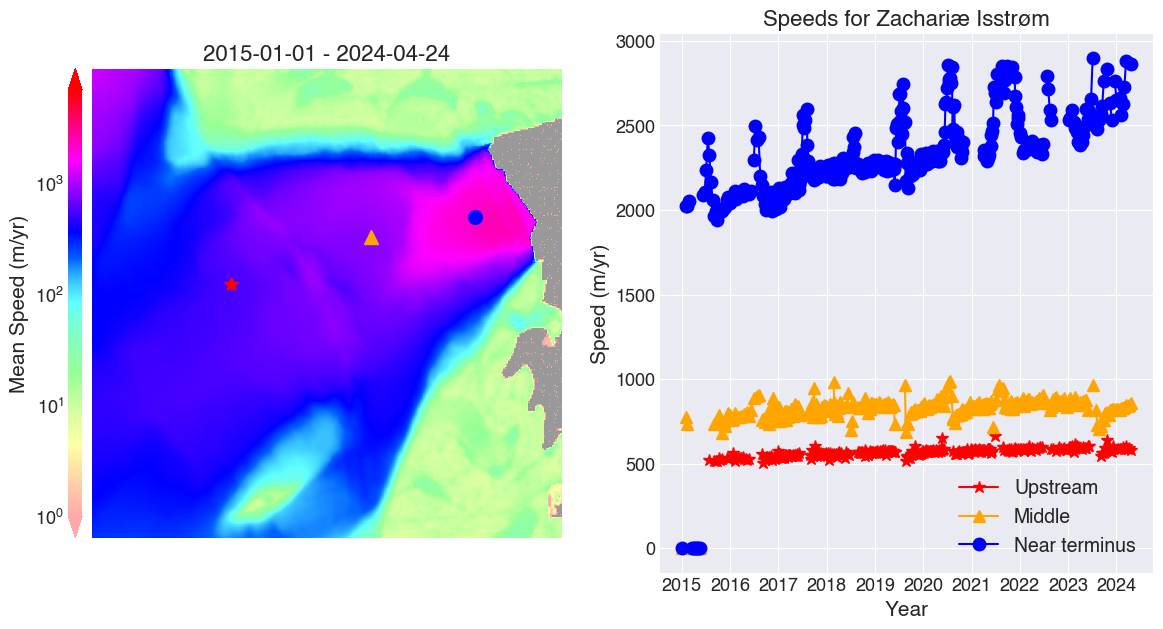

In [102]:
fig, axes = plt.subplots(1, 2, figsize=(14,7))
mapAxes, plotAxes = axes
# Map plot
velMean.displayVelForDate(ax=mapAxes, units='km', autoScale=True, axisOff=True, scale='log',
                                 midDate=False, colorBarLabel='Mean Speed (m/yr)', 
                                 extend='both', backgroundColor=(0.6, 0.6, 0.6), colorBarPosition='left', vmin=1, colorBarSize='3%', colorBarPad=.1)
# Loop to plot points
for x, y, symbol, color, label in zip(xpts, ypts, symbols, colors, labels):
    # plot points on map
    mapAxes.plot(x, y, symbol, color=color, markersize=10) 
    # plot values
    ziVelseries.plotPoint(x, y, ax=plotAxes, band='vv',  marker=symbol, color=color,  linestyle='-',
                          units='km', label=label, markersize=9)
# Finish plots
ziVelseries.labelPointPlot(xLabel='Year', yLabel='Speed (m/yr)', ax=plotAxes, title='Speeds for Zachariæ Isstrøm')
plotAxes.legend(fontsize=14)

[########################################] | 100% Completed | 317.15 ms
[########################################] | 100% Completed | 105.94 ms
[########################################] | 100% Completed | 1.68 sms
[########################################] | 100% Completed | 1.46 sms
[########################################] | 100% Completed | 1.26 sms
[########################################] | 100% Completed | 832.01 ms
[########################################] | 100% Completed | 945.20 ms
[########################################] | 100% Completed | 733.62 ms
[########################################] | 100% Completed | 841.81 ms
[########################################] | 100% Completed | 621.61 ms
[########################################] | 100% Completed | 844.59 ms
[########################################] | 100% Completed | 523.18 ms
[########################################] | 100% Completed | 730.48 ms
[########################################] | 100% Completed | 416.5

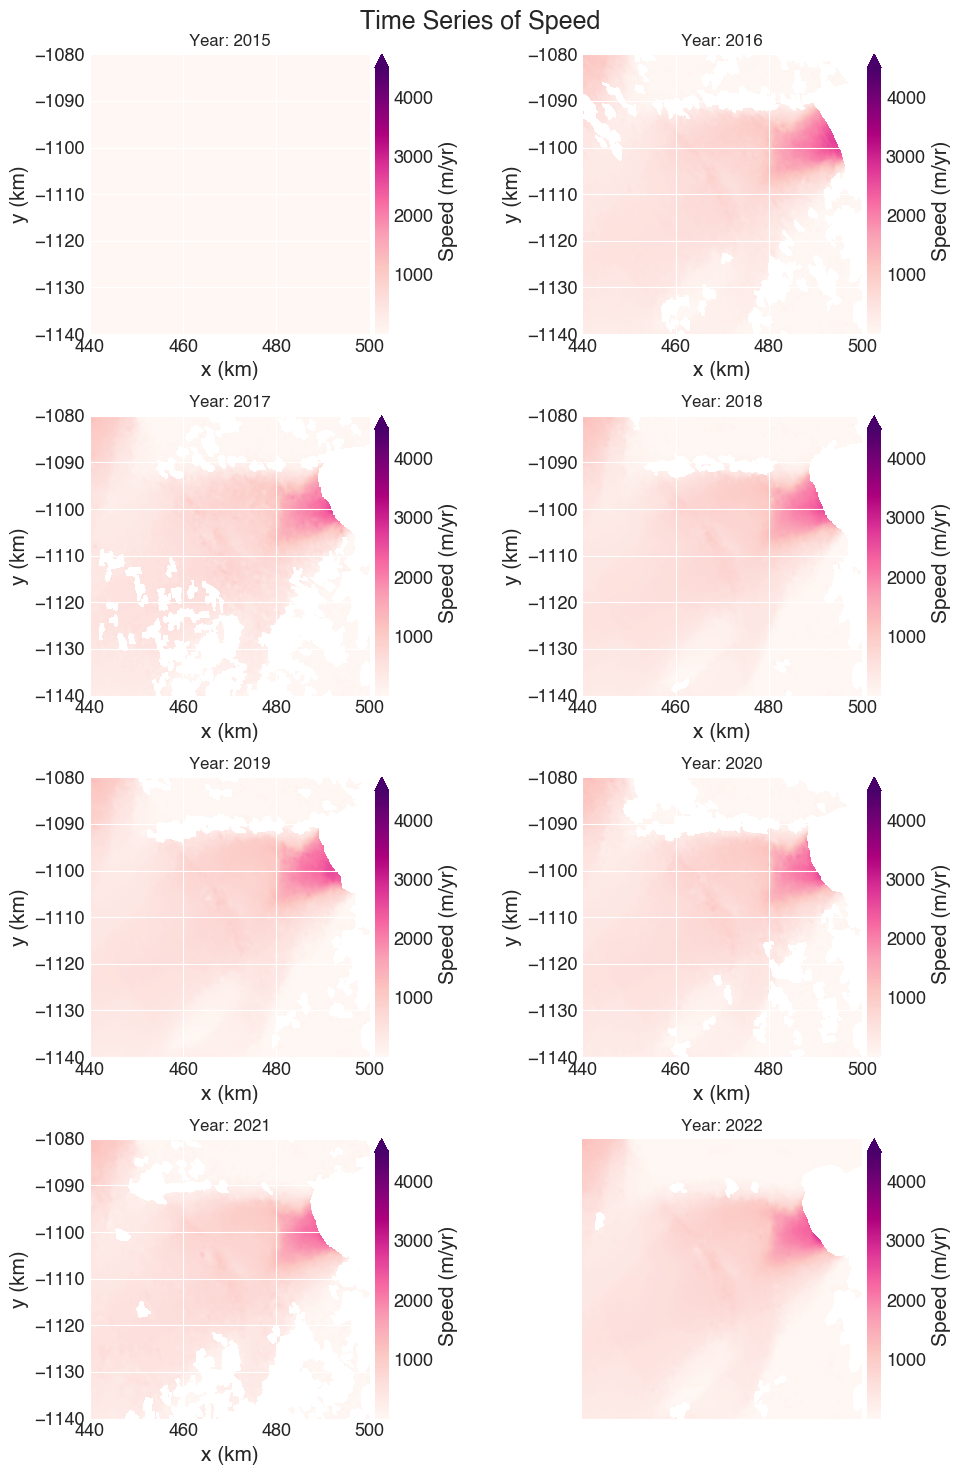

In [83]:
fig, axes = plt.subplots(4, 2, figsize=(10,15))

# Convert ziVelseries.time to a pandas Series to extract the year
time_series = pd.Series(ziVelseries.time)
years = time_series.dt.year.unique()

for ax, year in zip(axes.flatten(), years):
    dates_in_year = time_series[time_series.dt.year == year]
    if not dates_in_year.empty:
        ziVelseries.displayVelForDate(date=dates_in_year.iloc[0], ax=ax, autoScale=False, vmin=1, vmax=4500, units='km', axisOff=False, scale='linear')
        ax.set_title(f'Year: {year}')
axes[-1, -1].axis('off'); #remove any empty axes if odd number of years 
fig.suptitle('Time Series of Speed', fontsize=18)
fig.tight_layout()